<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/npr-working/isoscape_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isoscape Evals

Notebook Purpose: Eval isoscape generation methods for our paper

Isoscape Task: Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil.

# Import libraries required

In [2]:
import importlib
from datetime import datetime
import sys
import os

In [3]:
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_import_common()

executing checkout_branch ...
b''
main branch checked out as readonly. You may now use ddf_common imports


In [4]:
!pip install rasterio fiona

In [5]:
import train_variational_inference_model as tvim
import raster
import eeddf
import dataset
import fiona
import rasterio.mask
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount(raster.GDRIVE_BASE)

# Leave test_environment=True. Experiments must be done in test.
eeddf.initialize_ddf(test_environment=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


# Data configuration

In [6]:
# REQUIREMENTS:

# 1) Column names must match features_to_standardize, features_to_passthrough
# 2) Label columns in particular must match var_label and mean_label.
#
# If you used the data ingestion notebook (ingestion.ipynb) then this
# should be set up for you already.

# TRAINING FILE PARAMS
DATABASE_DIR = raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE
TRAINING_SET_FILE = 'demo_train_fixed_grouped.csv' #@param
VALIDATION_SET_FILE = 'demo_validation_fixed_grouped.csv' #@param
TEST_SET_FILE = 'demo_test_fixed_grouped.csv' #@param

# EVAL FILE PARAMS
EVAL_DATASET = 'demo_test_fixed_grouped.csv' #@param
ORIGINAL_DATASET = '2023_06_23_Results_Google.csv' #@param

fileset = {
    'TRAIN' : os.path.join(DATABASE_DIR, TRAINING_SET_FILE),
    'TEST' : os.path.join(DATABASE_DIR, VALIDATION_SET_FILE),
    'VALIDATION' : os.path.join(DATABASE_DIR, TEST_SET_FILE),
    'EVAL' : os.path.join(DATABASE_DIR, EVAL_DATASET),
    'ORIGINAL' : os.path.join(DATABASE_DIR, ORIGINAL_DATASET)
}

def prepare_dataset(params: tvim.VIModelTrainingParams, files: dict) -> dataset.ScaledPartitions:
  # Prepared columns not in the original input-- these are engineered features
  # that we believe include strong signals, stored as geotiffs
  potentially_extra_columns = [
      "brisoscape_mean_ISORIX",
      "d13C_cel_mean",
      "d13C_cel_var",
      "ordinary_kriging_linear_d18O_predicted_mean",
      "ordinary_kriging_linear_d18O_predicted_variance",
  ]

  #Load the geotiff it the params request it.
  extra_columns_from_geotiffs = {}
  for feature in params.features_to_passthrough + params.features_to_standardize:
      if feature in potentially_extra_columns:
          extra_columns_from_geotiffs[feature] = raster.column_name_to_geotiff_fn[feature]()

  return dataset.load_and_scale(
      files,
      params.mean_label,
      params.var_label,
      params.features_to_passthrough,
      [],
      params.features_to_standardize,
      extra_columns_from_geotiffs)

with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/bra_adm_ibge_2020_shp.zip') as shp:
  BRAZIL_SHP_MASK = [feature["geometry"] for feature in shp]

with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/Amazon Biome.zip/data/commondata/data0') as shp:
  AMAZON_SHP_MASK = [feature["geometry"] for feature in shp]

# Load these lazily later from the first generated isoscapes

def display_brazil(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, BRAZIL_SHP_MASK, crop=False)
    out_meta = src.meta
    brazil_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, brazil_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

def display_amazon(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, AMAZON_SHP_MASK, crop=False)
    out_meta = src.meta
    amazon_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, amazon_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

# Non-VI Models

## Ordinary Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/00_ordinary.html

In [6]:
!pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 8.7 MB/s eta 0:00:00


In [7]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [8]:
params = tvim.VIModelTrainingParams(
    training_id = "test-okrige-2024-10-25-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ordinary_kriging", "all_standardized", "linear_variogram"], #@param
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = 0.95, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")


In [9]:
data = prepare_dataset(params, fileset)

Driver: GTiff/GeoTIFF
Size is 541 x 467 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-73.922043, 5.233124)
Pixel Size = (0.08333, -0.08333)
Driver: GTiff/GeoTIFF
Size is 235 x 218 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0, 4.5)
Pixel Size = (0.16666668085106384, -0.1666666513761468)
Driver: GTiff/GeoTIFF
Size is 235 x 218 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTH

In [10]:
import pandas as pd
import numpy as np
import raster
import generate_isoscape
raw_train = pd.read_csv(fileset['TRAIN'])

In [27]:
def run_ordinary_kriging(**kwargs):
  # Not enough data to properly fit a Gaussian variogram
  ok = OrdinaryKriging(data.train.X['lat'], data.train.X['long'], data.train.Y['d18O_cel_mean'], **kwargs)

  min_long = min(data.train.X['long'])
  max_long = max(data.train.X['long'])
  min_lat = min(data.train.X['lat'])
  max_lat = max(data.train.X['lat'])

  # Predict the isotope values on the range of lattitude and longitude values
  # within the bounds of our VPD geotiff (should be Brazil-shaped), then save
  # for qualitative eval / display
  isoscape_long_values =  np.linspace(min_long, max_long, params.resolution_x)
  isoscape_lat_values = np.linspace(min_lat, max_lat, params.resolution_y)

  means, variances  = ok.execute("grid", isoscape_long_values,
                                  isoscape_lat_values)
  ok.print_statistics()

  arbitrary_geotiff = raster.vapor_pressure_deficit_geotiff()
  base_bounds = raster.get_extent(arbitrary_geotiff.gdal_dataset)
  final_bounds = raster.create_bounds_from_res(params.resolution_x, params.resolution_y, base_bounds)

  all_predictions = np.ma.masked_array([means, variances], mask=[np.isnan(means), np.isnan(variances)]) # raster, lat, lon
  all_predictions = np.transpose(all_predictions, axes=[1, 2, 0]) # lat, lon, raster

  generate_isoscape.save_numpy_to_geotiff(final_bounds, all_predictions, ISOSCAPE_SAVE_LOCATION)

  # Quantitative Eval Metrics
  test_pred_means, test_pred_vars  = ok.execute("points", data.test.X['long'],
                                  data.test.X['lat'])
  test_ground_means = data.test.Y[params.mean_label]
  test_ground_vars = data.test.Y[params.var_label]
  print(f'Means RMSE: {np.sqrt(mean_squared_error(test_ground_means, test_pred_means))}')
  print(f'Variances RMSE: {np.sqrt(mean_squared_error(test_ground_vars, test_pred_vars))}')



In [28]:
# Not enough data for a gaussian variogram (we only use the 'train' split)
run_ordinary_kriging(variogram_model='linear')

Q1 = None
Q2 = None
cR = None
Means RMSE: 1.433652652305679
Variances RMSE: 1.0005289219161295


In [ ]:
display_brazil(0) # Means

In [ ]:
display_amazon(0) # Means

## Universal Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/01_universal.html

In [1]:
!pip install pykrige

In [13]:
params = tvim.VIModelTrainingParams(
    training_id = "test-ukrige-2024-10-25-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "universal_kriging", "all_standardized", "linear_variogram"], #@param
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = 0.95, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")


In [14]:
data = prepare_dataset(params, fileset)

In [15]:
import pandas as pd
import numpy as np
import raster
import pykrige.kriging_tools as kt
from pykrige.uk import UniversalKriging
from sklearn.metrics import mean_squared_error
raw_train = pd.read_csv(fileset['TRAIN'])

In [23]:
def run_universal_kriging(**kwargs):
  uk = UniversalKriging(data.train.X['lat'], data.train.X['long'], data.train.Y['d18O_cel_mean'], **kwargs)
  min_long = min(data.train.X['long'])
  max_long = max(data.train.X['long'])
  min_lat = min(data.train.X['lat'])
  max_lat = max(data.train.X['lat'])

  # Predict the isotope values on the range of lattitude and longitude values
  # within the bounds of our VPD geotiff (should be Brazil-shaped), then save
  # for qualitative eval / display
  isoscape_long_values =  np.linspace(min_long, max_long, params.resolution_x)
  isoscape_lat_values = np.linspace(min_lat, max_lat, params.resolution_y)
  means, variances  = uk.execute("grid", isoscape_long_values,
                                  isoscape_lat_values)
  uk.print_statistics()

  arbitrary_geotiff = raster.vapor_pressure_deficit_geotiff()
  base_bounds = raster.get_extent(arbitrary_geotiff.gdal_dataset)
  final_bounds = raster.create_bounds_from_res(params.resolution_x, params.resolution_y, base_bounds)

  all_predictions = np.ma.masked_array([means, variances], mask=[np.isnan(means), np.isnan(variances)]) # raster, lat, lon
  all_predictions = np.transpose(all_predictions, axes=[1, 2, 0]) # lat, lon, raster

  generate_isoscape.save_numpy_to_geotiff(final_bounds, all_predictions, ISOSCAPE_SAVE_LOCATION)

  # Quantitative Eval Metrics
  test_pred_means, test_pred_vars  = uk.execute("points", data.test.X['long'],
                                  data.test.X['lat'])
  test_ground_means = data.test.Y[params.mean_label]
  test_ground_vars = data.test.Y[params.var_label]
  print(f'Means RMSE: {np.sqrt(mean_squared_error(test_ground_means, test_pred_means))}')
  print(f'Variances RMSE: {np.sqrt(mean_squared_error(test_ground_vars, test_pred_vars))}')


In [24]:
run_universal_kriging(variogram_model='gaussian', drift_terms=['regional_linear'])

Q1 = 0.03882876959527777
Q2 = 2.436161167322317
cR = 1.5016620429456022
Means RMSE: 1.0606534598056683
Variances RMSE: 7.894642044056291


In [ ]:
display_brazil(0)

## Regression Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/07_regression_kriging2d.html

In [ ]:
!pip install pykrige

In [70]:
params = tvim.VIModelTrainingParams(
    training_id = "test-rkrige-2024-10-25-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = ['lat', 'long'], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "regression_kriging", "all_standardized"], #@param
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = 0.95, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")

In [135]:
import pandas as pd
import numpy as np
import raster
from numpy.typing import NDArray
from typing import Tuple, List

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import generate_isoscape
import model

from pykrige.rk import RegressionKriging


def run_regression_kriging(regression_model, regression_kwargs, krige_kwargs):
  data = prepare_dataset(params, fileset)
  raw_train = pd.read_csv(fileset['TRAIN']).dropna()
  raw_val = pd.read_csv(fileset['VALIDATION']).dropna()

  svr_model = SVR(C=0.1, gamma="auto")
  rf_model = RandomForestRegressor(n_estimators=1000)
  lr_model = LinearRegression(copy_X=True, fit_intercept=True)
  gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=20)

  models = [svr_model, rf_model, lr_model]

  train_features = params.features_to_standardize + params.features_to_passthrough
  train_features_nolatlon = list(train_features)
  train_features_nolatlon.remove('lat')
  train_features_nolatlon.remove('long')

  p_train = pd.concat((data.train.X[train_features_nolatlon], data.val.X[train_features_nolatlon],), join='inner')
  x_train = np.concatenate((np.array(tuple(zip(raw_train['lat'], raw_train['long']))), np.array(tuple(zip(raw_val['lat'], raw_val['long'])))))
  target_train = pd.concat((raw_train[params.mean_label], raw_val[params.mean_label],), join='inner')


  rk = RegressionKriging(regression_model=regression_model(**regression_kwargs), **krige_kwargs)
  # Why do I call .to_numpy() here?
  # to_numpy() removes feature names, which ColumnTransformer.transform() strips
  # in predict_on_batch(). If trained with feature names but inference is run
  # without, a long list of warnings will be printed and isoscape generation will
  # be slower.
  rk.fit(p_train.to_numpy(), x_train, target_train)


  class DDFRegressionKrigingModel(model.Model):
    # #@override
    def __init__(self, rk: RegressionKriging, training_cols: List[str]):
      self.rk = rk
      self.training_cols = training_cols

    # #@override
    def predict_on_batch(self, X: pd.DataFrame) -> NDArray[np.float32]:
      #TODO(ruru): Maybe our isoscape generator should standardize the features in features_to_standardize here as well
      #TODO: The scaling step appears to add some time. This might be a good target for future performance efforts.
      XT = data.feature_scaler.transform(X)
      latindex = X.columns.get_loc('lat')
      longindex = X.columns.get_loc('long')
      x = X[['lat', 'long']].to_numpy()
      p = np.delete(XT, [latindex, longindex],axis=1)
      means = self.rk.predict(p, x)
      return np.array([means, np.zeros(means.shape)]).T

    # #@override
    def training_column_names(self) -> List[str]:
      return ['lat', 'long'] + self.training_cols


  rkm = DDFRegressionKrigingModel(rk=rk, training_cols=train_features_nolatlon)



  # Quantitative Eval Metrics
  test_preds = rkm.predict_on_batch(data.test.X)
  test_pred_means = test_preds[:,0]
  test_ground_means = data.test.Y[params.mean_label]
  print(f'Means RMSE: {np.sqrt(mean_squared_error(test_ground_means, test_pred_means))}')


  generate_isoscape.generate_isoscapes_from_variational_model(rkm, 1024, 1024, ISOSCAPE_SAVE_LOCATION)


In [ ]:
run_regression_kriging(GradientBoostingRegressor, {'n_estimators':100, 'max_depth':20}, {'method': 'universal', 'variogram_model':'gaussian', 'drift_terms':['regional_linear']})

In [ ]:
display_brazil(0)

In [ ]:
display_amazon(0)

## MCMC?

In [ ]:
# https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98

# Variational Inference + DNN

In [ ]:
# Convenience links:
# Paper: https://braintex.goog/project/6509cbf324c22900a893d018
# Experiment list: https://docs.google.com/spreadsheets/d/1QUGvdUkkYCnflTytaYelMsbzGjhvR0U_HBkRdDUdeGM/edit?gid=1787854098#gid=1787854098
#

In [14]:
params = tvim.VIModelTrainingParams(
    training_id = "test-2024-10-25-foobar", #@param
    num_epochs = 5000, #@param
    num_layers = 2, #@param
    num_nodes_per_layer = 20, #@param
    training_batch_size = 5, #@param
    learning_rate = 0.0001, #@param
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = 100, #@param
    double_sided_kl = False, #@param
    kl_num_samples_from_pred_dist = 15, #@param
    dropout_rate = 0, #@param
    activation_func = "relu", #@param
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ViNN"], #@param
    foo = "bar"
)



In [15]:
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = 0.95, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)

# Train the model

test-2024-10-25-foobar


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20)             │            340 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 20)             │            420 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ var_output (Dense)        │ (None, 1)              │             21 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean_output (Dense)       │ (None, 1)              │             21 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 1)              │              0 │ var_output[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1)              │              0 │ mean_output[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1)              │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1)              │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 1)              │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 1)              │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softplus_layer            │ (None, 1)              │              0 │ cast[0][0]             │
│ (SoftplusLayer)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ cast_1[0][0],          │
│                           │                        │                │ softplus_layer[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 460: early stopping
Restoring model weights from the end of the best epoch: 360.


/tmp/ddf_common/model.py:233: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


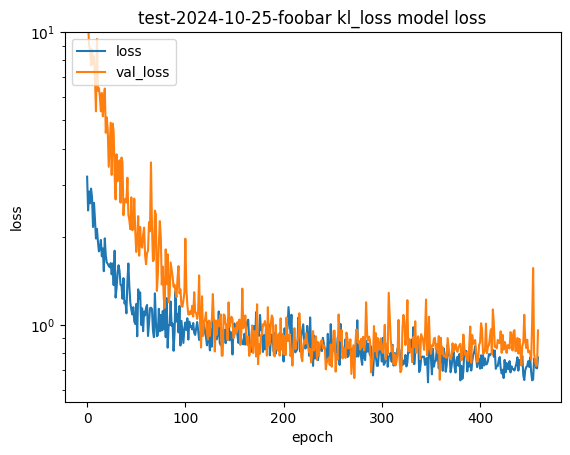

Val loss: 0.6480587124824524
Train loss: 0.8041459918022156
Test loss: 1.117887258529663
dO18 RMSE: 1.2302832411727829


100%|██████████| 1024/1024 [02:09<00:00,  7.94it/s]


Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


Streaming output truncated to the last 5000 lines.
/tmp/ddf_common/hypothesis.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  isotope_variance = isotope_variances[i]
/tmp/ddf_common/hypothesis.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_sample_size = isotope_counts[i]
/tmp/ddf_common/hypothesis.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  isotope_variance = isotope_variances[i]
/tmp/ddf_common/hypothesis.p

In [16]:
EVAL_ONLY = False #@param{type:'boolean'}
res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

# Optional Rendering

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

means_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=0)
raster.animate(means_isoscape,  1, 1)

In [ ]:
vars_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=1)
raster.animate(vars_isoscape,  1, 1)